# Подготовка датасета news

In [250]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm.auto import tqdm
import pickle

import scipy as sp
import string

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import nltk
import scikitplot as skplt

import re, string

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
STOPWORDS = set(stopwords.words('russian'))
#list of special characters.You can use regular expressions too
# importing the PorterStemmer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize,word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#importing the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import SnowballStemmer

from pymorphy2 import MorphAnalyzer

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

import gensim
from gensim.models import Word2Vec

import fasttext
from fasttext import train_supervised

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\150ho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\150ho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\150ho\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [251]:
import datetime
import pathlib
import glob

import random
from collections import Counter

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import BertForSequenceClassification

In [252]:
plt.style.use('ggplot')

In [253]:
# !pip install fastText

In [254]:
sym1 = 'SBERP'
sym2 = 'SBER'

In [255]:
df_news = pd.read_csv(f'smartlab_{sym2}_new.csv')
df_news['time'] = df_news['time'].map(lambda x: x[:10])
df_news['time'] = pd.to_datetime(df_news['time'], format='%Y-%m-%d')
df_news = df_news[['time', 'text']]
df_news

,time,text
0,2011-01-11,Первый зампред Банка России Алексей Улюкаев.«...
1,2011-01-25,Сбербанк опубликовал финансовые результаты по ...
2,2011-02-14,Сбербанк совместно с Центральным банком (ЦБ) Р...
3,2011-02-25,Два дня назад (22 февраля) я затарился Сбером ...
4,2011-03-22,Чистая прибыль — рекордные 182 млрд рублейЭто ...
...,...,...
4149,2023-12-06,Основные положения дивидендной политики Сбера ...
4150,2023-12-06,"Греф заявил, что 2023 г. будет самым успешным ..."
4151,2023-12-06,"Нет планов уходить из Сбера, но Набсовет часто..."
4152,2023-12-06,Греф про выкуп акций у нерезидентов: всё возмо...


In [256]:
df_news1 = df_news['text'].groupby(df_news['time']).apply(list).reset_index()
df_news1['text'] = df_news1['text'].apply(lambda x: x[0])
df_news1.set_index('time', inplace=True)
df_news1 = df_news1[df_news1.index > "2016-01-01"]
df_news1

,text
time,
2016-01-13,Сегодня у нас проходит т.н. гайдаровский форум...
2016-01-15,Сбер представил отчет по РСБУ. Вклады населени...
2016-01-18,Мы будем предлагатьсказал Улюкаев. Чтобы прив...
2016-01-20,"Здравствуйте, сегодня наткнулся на ткую новост..."
2016-01-21,"Коммерсант сегодня написал, что Керимов хочет ..."
...,...
2023-12-01,Совкомбанк занимает 8 место по активам среди р...
2023-12-02,Правительство принимает «некоторые меры» для п...
2023-12-04,Российские банки выдадут ипотечных кредитов по...


In [257]:
df_stock = pd.read_csv(f'{sym1}_day.csv', index_col=0, parse_dates=True)
df_stock = df_stock[['CLOSE']]
df_stock = df_stock[df_stock.index > "2016-01-01"]
df_stock

,CLOSE
DATE,
2016-01-04,73.88
2016-01-05,74.23
2016-01-06,72.62
2016-01-11,69.11
2016-01-12,69.32
...,...
2023-11-30,276.95
2023-12-01,273.85
2023-12-04,270.30


In [258]:
df = pd.concat([df_stock, df_news1], axis=1)
df

,CLOSE,text
2016-01-04,73.88,NaN
2016-01-05,74.23,NaN
2016-01-06,72.62,NaN
2016-01-11,69.11,NaN
2016-01-12,69.32,NaN
...,...,...
2023-12-01,273.85,Совкомбанк занимает 8 место по активам среди р...
2023-12-02,NaN,Правительство принимает «некоторые меры» для п...
2023-12-04,270.30,Российские банки выдадут ипотечных кредитов по...
2023-12-05,279.15,В России могут повысить первоначальный взнос п...


In [259]:
df.isna().sum()

CLOSE     57
text     576
dtype: int64

In [260]:
df['CLOSE'].fillna(method='ffill', inplace=True)

In [261]:
df['Target'] = df['CLOSE'] - df['CLOSE'].shift()
df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(len(df))]
df

,CLOSE,text,Target,TargetClass
2016-01-04,73.88,NaN,NaN,0
2016-01-05,74.23,NaN,0.35,1
2016-01-06,72.62,NaN,-1.61,0
2016-01-11,69.11,NaN,-3.51,0
2016-01-12,69.32,NaN,0.21,1
...,...,...,...,...
2023-12-01,273.85,Совкомбанк занимает 8 место по активам среди р...,-3.10,0
2023-12-02,273.85,Правительство принимает «некоторые меры» для п...,0.00,0
2023-12-04,270.30,Российские банки выдадут ипотечных кредитов по...,-3.55,0
2023-12-05,279.15,В России могут повысить первоначальный взнос п...,8.85,1


In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2043 entries, 2016-01-04 to 2023-12-06
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CLOSE        2043 non-null   float64
 1   text         1467 non-null   object 
 2   Target       2042 non-null   float64
 3   TargetClass  2043 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 79.8+ KB


In [263]:
df = df.dropna()
df = df[['text', 'TargetClass']].reset_index(drop = True)
df

,text,TargetClass
0,Сегодня у нас проходит т.н. гайдаровский форум...,1
1,Сбер представил отчет по РСБУ. Вклады населени...,0
2,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0
3,"Здравствуйте, сегодня наткнулся на ткую новост...",0
4,"Коммерсант сегодня написал, что Керимов хочет ...",1
...,...,...
1462,Совкомбанк занимает 8 место по активам среди р...,0
1463,Правительство принимает «некоторые меры» для п...,0
1464,Российские банки выдадут ипотечных кредитов по...,0
1465,В России могут повысить первоначальный взнос п...,1


In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467 entries, 0 to 1466
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         1467 non-null   object
 1   TargetClass  1467 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.0+ KB


In [265]:
df.to_csv(f'{sym1}_dataset_news.csv', index = False)

In [266]:
# pd.read_csv(f'{sym1}_dataset_news.csv')

In [267]:
df['TargetClass'].value_counts()

1    744
0    723
Name: TargetClass, dtype: int64

# Предпроцессинг

In [18]:
ps = SnowballStemmer(language="russian")
lemmatizer = MorphAnalyzer()

In [110]:
data = df.rename({'TargetClass':'Class','text':'Message'},axis=1)
data

,Message,Class
2016-01-13,Сегодня у нас проходит т.н. гайдаровский форум...,1
2016-01-15,Сбер представил отчет по РСБУ. Вклады населени...,0
2016-01-18,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0
2016-01-20,"Здравствуйте, сегодня наткнулся на ткую новост...",0
2016-01-21,"Коммерсант сегодня написал, что Керимов хочет ...",1
...,...,...
2023-11-24,"Как узнал “Ъ”, крупные банки исчерпали лимиты ...",1
2023-11-27,Динамика рынка POS-кредитования (point of sale...,0
2023-11-28,"«Банки вернулись в хорошую форму, пора думать ...",0
2023-11-29,Сбербанк отмечает улучшение ситуации с реструк...,0


In [112]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]+|[\d]+', r'',text).strip()
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub(' ', text)
#     text = re.sub(r'[^0-9a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = " ".join(word for word in text.split() if word not in STOPWORDS)
    text = " ".join(ps.stem(lemmatizer.normal_forms(word)[0]) for word in text.split())
    return text
  
data['clean_text'] = data['Message'].apply(clean_text)
data.head()

In [17]:
#define a function to get rid of stopwords present in the messages
def message_text_process(mess):
    # Check characters to see if there are punctuations 
    no_punctuation=[char for char in mess if char not in string.punctuation]
    # now form the sentence
    no_punctuation=''.join(no_punctuation)
    # Now eliminate any stopwords
    return[word for word in no_punctuation.split() if word.lower() not in stopwords.words('english') and stopwords.words('russian')]

# to verify that function is working
data['Message_text_process'] = data['Message'].apply(message_text_process)
data

,Message,Class,clean_text,Message_text_process
2016-01-13,Сегодня у нас проходит т.н. гайдаровский форум...,1,сегодн проход тн гайдаровск форум дела различн...,"[Сегодня, у, нас, проходит, тн, гайдаровский, ..."
2016-01-15,Сбер представил отчет по РСБУ. Вклады населени...,0,сбер представ отчет рсб вклад населен трлн руб...,"[Сбер, представил, отчет, по, РСБУ, Вклады, на..."
2016-01-18,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0,быт предлагатьсказа улюка приватизирова сбер к...,"[Мы, будем, предлагатьсказал, Улюкаев, Чтобы, ..."
2016-01-20,"Здравствуйте, сегодня наткнулся на ткую новост...",0,здравств сегодн наткнут ткова новостьбумаг пер...,"[Здравствуйте, сегодня, наткнулся, на, ткую, н..."
2016-01-21,"Коммерсант сегодня написал, что Керимов хочет ...",1,коммерсант сегодн написа кер хотет обкеш компа...,"[Коммерсант, сегодня, написал, что, Керимов, х..."
...,...,...,...,...
2023-11-23,Прирост ипотечного портфеля в 2023г превысил 3...,0,прирост ипотечн портфел г превыс трлн руб г тр...,"[Прирост, ипотечного, портфеля, в, 2023г, прев..."
2023-11-24,"Как узнал “Ъ”, крупные банки исчерпали лимиты ...",1,узна ь крупн банк исчерпа лим финансирован льг...,"[Как, узнал, “Ъ”, крупные, банки, исчерпали, л..."
2023-11-27,Динамика рынка POS-кредитования (point of sale...,0,динамик рынок поскредитован point of sales кре...,"[Динамика, рынка, POSкредитования, point, sale..."
2023-11-28,"«Банки вернулись в хорошую форму, пора думать ...",0,банк вернут хорош форм пор дума развит сообщ п...,"[«Банки, вернулись, в, хорошую, форму, пора, д..."


In [18]:
data['Message_clean_text_process'] = data['clean_text'].apply(message_text_process)
data

,Message,Class,clean_text,Message_text_process,Message_clean_text_process
2016-01-13,Сегодня у нас проходит т.н. гайдаровский форум...,1,сегодн проход тн гайдаровск форум дела различн...,"[Сегодня, у, нас, проходит, тн, гайдаровский, ...","[сегодн, проход, тн, гайдаровск, форум, дела, ..."
2016-01-15,Сбер представил отчет по РСБУ. Вклады населени...,0,сбер представ отчет рсб вклад населен трлн руб...,"[Сбер, представил, отчет, по, РСБУ, Вклады, на...","[сбер, представ, отчет, рсб, вклад, населен, т..."
2016-01-18,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0,быт предлагатьсказа улюка приватизирова сбер к...,"[Мы, будем, предлагатьсказал, Улюкаев, Чтобы, ...","[быт, предлагатьсказа, улюка, приватизирова, с..."
2016-01-20,"Здравствуйте, сегодня наткнулся на ткую новост...",0,здравств сегодн наткнут ткова новостьбумаг пер...,"[Здравствуйте, сегодня, наткнулся, на, ткую, н...","[здравств, сегодн, наткнут, ткова, новостьбума..."
2016-01-21,"Коммерсант сегодня написал, что Керимов хочет ...",1,коммерсант сегодн написа кер хотет обкеш компа...,"[Коммерсант, сегодня, написал, что, Керимов, х...","[коммерсант, сегодн, написа, кер, хотет, обкеш..."
...,...,...,...,...,...
2023-11-23,Прирост ипотечного портфеля в 2023г превысил 3...,0,прирост ипотечн портфел г превыс трлн руб г тр...,"[Прирост, ипотечного, портфеля, в, 2023г, прев...","[прирост, ипотечн, портфел, г, превыс, трлн, р..."
2023-11-24,"Как узнал “Ъ”, крупные банки исчерпали лимиты ...",1,узна ь крупн банк исчерпа лим финансирован льг...,"[Как, узнал, “Ъ”, крупные, банки, исчерпали, л...","[узна, ь, крупн, банк, исчерпа, лим, финансиро..."
2023-11-27,Динамика рынка POS-кредитования (point of sale...,0,динамик рынок поскредитован point of sales кре...,"[Динамика, рынка, POSкредитования, point, sale...","[динамик, рынок, поскредитован, point, sales, ..."
2023-11-28,"«Банки вернулись в хорошую форму, пора думать ...",0,банк вернут хорош форм пор дума развит сообщ п...,"[«Банки, вернулись, в, хорошую, форму, пора, д...","[банк, вернут, хорош, форм, пор, дума, развит,..."


# TF-IDF BOW

In [19]:
X = data['clean_text']
y = data['Class']

In [20]:
def Model(model, X, y):
#training and testing the data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # model building using CountVectorizer and TfidfTransformer
    pipeline_model = Pipeline([('vect', CountVectorizer(ngram_range = (1,3))),
#                                ('TfidfVect', TfidfVectorizer()),
                              ('tfidf', TfidfTransformer()),
                              ('clf', model)])
    pipeline_model.fit(x_train, y_train)
    
    


    y_pred = pipeline_model.predict(x_test)
    y_probas =pipeline_model.predict_proba(x_test)
    skplt.metrics.plot_roc(y_test,y_probas,figsize=(12,8),title_fontsize=12,text_fontsize=16)
    plt.show()
    skplt.metrics.plot_precision_recall(y_test,y_probas,figsize=(12,8),title_fontsize=12,text_fontsize=16)
    plt.show()
    print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
    print("Classification Report is:\n",classification_report(y_test, y_pred))
    print('Accuracy:', pipeline_model.score(x_test, y_test)*100)
    print("Training Score:\n",pipeline_model.score(x_train,y_train)*100)

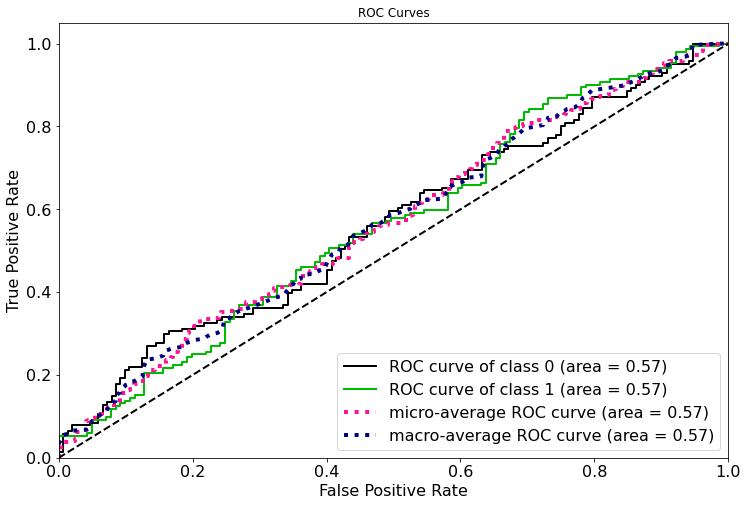

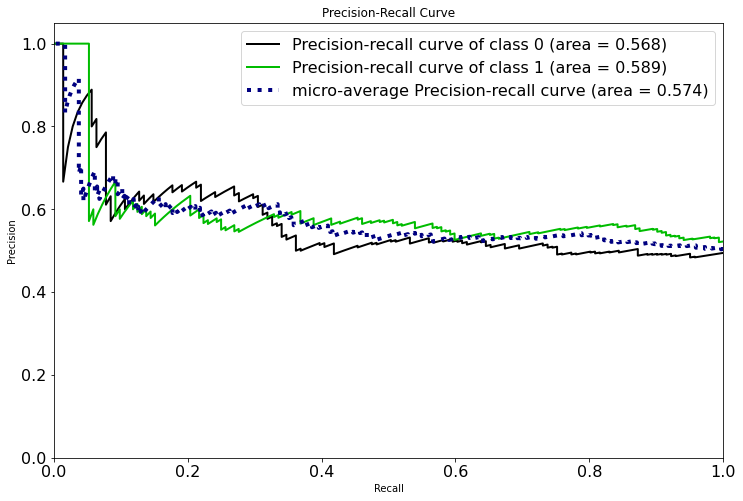

Confusion Matrix:
 [[72 69]
 [65 87]]
Classification Report is:
               precision    recall  f1-score   support

           0       0.53      0.51      0.52       141
           1       0.56      0.57      0.56       152

    accuracy                           0.54       293
   macro avg       0.54      0.54      0.54       293
weighted avg       0.54      0.54      0.54       293

Accuracy: 54.26621160409556
Training Score:
 99.7431506849315
CPU times: total: 9.27 s
Wall time: 6.68 s


In [21]:
%%time
model1 = LogisticRegression()
Model(model1, X, y)

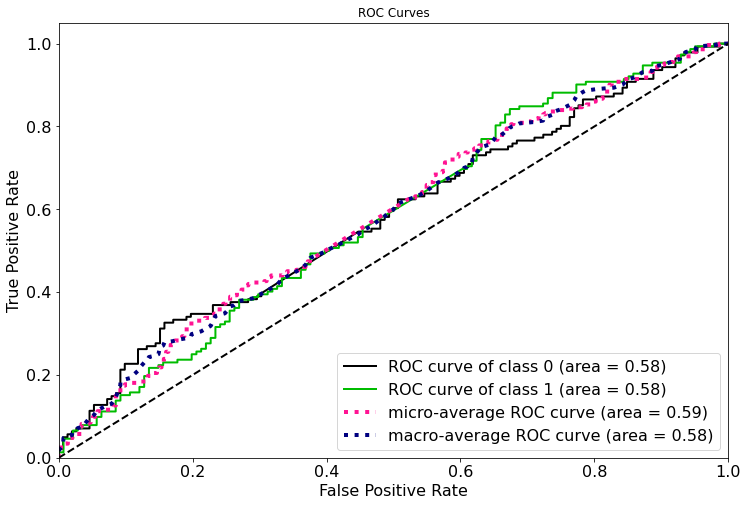

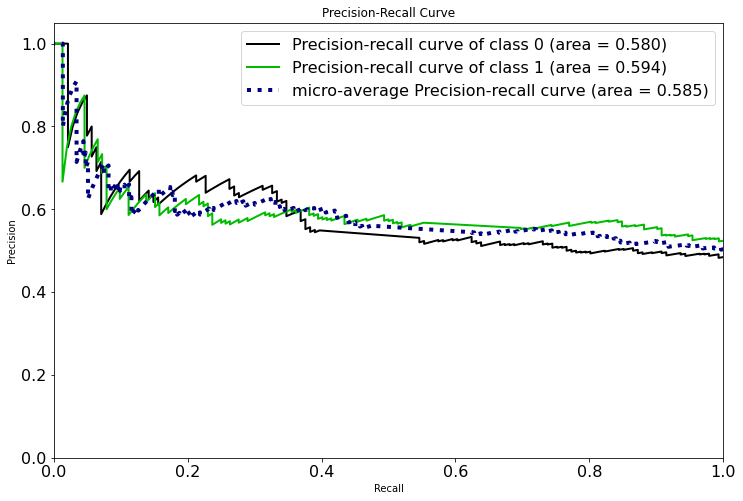

Confusion Matrix:
 [[74 67]
 [65 87]]
Classification Report is:
               precision    recall  f1-score   support

           0       0.53      0.52      0.53       141
           1       0.56      0.57      0.57       152

    accuracy                           0.55       293
   macro avg       0.55      0.55      0.55       293
weighted avg       0.55      0.55      0.55       293

Accuracy: 54.94880546075085
Training Score:
 99.7431506849315
CPU times: total: 26 s
Wall time: 26.3 s


In [22]:
%%time
model2 = SVC(kernel='linear',probability=True)
Model(model2, X, y)

In [23]:
#function for the model building and prediction
def Model1(model, X, y):
#training and testing the data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # model building using CountVectorizer and TfidfTransformer
    pipeline_model = Pipeline([('vect', CountVectorizer(ngram_range = (1,3))),
                              ('tfidf', TfidfTransformer()),
                              ('clf', model)])
    pipeline_model.fit(x_train, y_train)
    
    


    y_pred = pipeline_model.predict(x_test)
    print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
    print("Classification Report is:\n",classification_report(y_test, y_pred))
    print('Accuracy:', pipeline_model.score(x_test, y_test)*100)
    print("Training Score:\n",pipeline_model.score(x_train,y_train)*100)

In [24]:
%%time
model3 = LinearSVC()
Model1(model3, X, y)

Confusion Matrix:
 [[75 66]
 [66 86]]
Classification Report is:
               precision    recall  f1-score   support

           0       0.53      0.53      0.53       141
           1       0.57      0.57      0.57       152

    accuracy                           0.55       293
   macro avg       0.55      0.55      0.55       293
weighted avg       0.55      0.55      0.55       293

Accuracy: 54.94880546075085
Training Score:
 100.0
CPU times: total: 3.89 s
Wall time: 3.97 s


In [25]:
with open("model1.pkl", "wb") as f:
    pickle.dump(model1, f)
    
with open("model2.pkl", "wb") as f:
    pickle.dump(model2, f)

with open("model3.pkl", "wb") as f:
    pickle.dump(model3, f)

In [26]:
# with open("model.pkl", "rb") as f:
#     model = pickle.load(f)

# Word2Vec

https://colab.research.google.com/github/PragmaticsLab/NLP-course-FinTech/blob/master/seminars/2/2_embeddings.ipynb
https://python-school.ru/blog/word2vec-with-examples-in-gensim/

### обучаем свою модель

In [18]:
#define a function to get rid of stopwords present in the messages
def message_text_process11(text):
    text = re.sub(r'http\S+', '', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]+|[\d]+', r'',text).strip()
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub(' ', text)
# #     text = re.sub(r'[^0-9a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
#     text = " ".join(word for word in text.split() if word not in STOPWORDS)
    text = " ".join(lemmatizer.normal_forms(word)[0] for word in text.split())
    
    # Check characters to see if there are punctuations 
    no_punctuation=[char for char in text if char not in string.punctuation]
    # now form the sentence
    no_punctuation=''.join(no_punctuation)
    
    
    
    # Now eliminate any stopwords
    return[word for word in no_punctuation.split() if word.lower() not in stopwords.words('english') and stopwords.words('russian')]

# to verify that function is working
data1 = data['Message'].apply(message_text_process11)
data1

2016-01-13    [сегодня, у, мы, проходить, тн, гайдаровский, ...
2016-01-15    [сбер, представить, отчёт, по, рсб, вклад, нас...
2016-01-18    [мы, быть, предлагатьсказать, улюкай, чтобы, п...
2016-01-20    [здравствуйте, сегодня, наткнуться, на, тковат...
2016-01-21    [коммерсант, сегодня, написать, что, керим, хо...
                                    ...                        
2023-11-24    [как, узнать, ъ, крупный, банк, исчерпать, лим...
2023-11-27    [динамика, рынок, posкредитование, point, sale...
2023-11-28    [банк, вернуться, в, хороший, форма, пора, дум...
2023-11-29    [сбербанк, отмечать, улучшение, ситуация, с, р...
2023-11-30    [правительство, россия, распространить, действ...
Name: Message, Length: 1462, dtype: object

In [87]:
w2v_model = Word2Vec(
    min_count=10,
    window=2,
    vector_size=300,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

In [88]:
w2v_model.build_vocab(data1)

In [89]:
w2v_model.train(data1, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(4182232, 11197290)

In [97]:
w2v_model.wv.most_similar(positive=["хорошо"], topn=10)

[('воспринять', 0.6355305314064026),
 ('всегда', 0.6045184135437012),
 ('казаться', 0.6028740406036377),
 ('посмотреть', 0.5869712233543396),
 ('правильный', 0.5761329531669617),
 ('насколько', 0.5743809342384338),
 ('легко', 0.5691114664077759),
 ('потому', 0.5672942996025085),
 ('я', 0.5629263520240784),
 ('приемлемый', 0.5610839128494263)]

In [133]:
w2v_model.wv.most_similar(positive=["хорошо"], topn=1)[0][0]

'воспринять'

In [130]:
# w2v_model.wv.word_vec("хорошо")

In [129]:
# w2v_model.wv["хорошо"]

In [99]:
w2v_model.wv.vectors.shape

(3446, 300)

In [100]:
w2v_model.wv.vectors

array([[-0.05483741,  0.12492273,  0.20600459, ..., -0.2820193 ,
         0.14776455, -0.0715675 ],
       [-0.07739273, -0.1477236 ,  0.02727326, ..., -0.12880914,
         0.19976835, -0.26123103],
       [ 0.02566761,  0.11109508,  0.20854254, ..., -0.07565638,
         0.03179994,  0.05433212],
       ...,
       [ 0.01620821, -0.0547593 , -0.13079768, ..., -0.04612351,
         0.02444964,  0.12622792],
       [-0.05195332, -0.09643837, -0.08137736, ...,  0.00303858,
         0.04654838, -0.2470814 ],
       [-0.01222625, -0.02162284, -0.02555733, ..., -0.03320246,
        -0.01493341, -0.04800824]], dtype=float32)

In [101]:
# save model in ASCII (word2vec) format
filename1 = 'w2v_model.txt'
w2v_model.wv.save_word2vec_format(filename1, binary=False)

In [102]:
embeddings_i = {}
f = open(os.path.join('', 'w2v_model.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_i[word] = coefs
f.close()

In [105]:
docs_vectors2 = pd.DataFrame() # creating empty final dataframe
# stopwords = nltk.corpus.stopwords.words('english') # removing stop words
for doc in tqdm(data1):#.str.lower().str.replace('[^a-z ]', ''): # looping through each document and cleaning it
    temp2 = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    for word in doc: # looping through each word of a single document and spliting through space
#         if word not in STOPWORDS: # if word is not present in stopwords then (try)
        try:
                    word_vec2 = embeddings_i[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                    temp21 = temp2.append(pd.Series(word_vec2), ignore_index = True) # if word is present then append it to temporary dataframe
        except:
                    pass
            
    doc_vector2 = temp21.mean() # take the average of each column(w0, w1, w2,........w300)
    docs_vectors2 = docs_vectors2.append(doc_vector2, ignore_index = True) # append each document value to the final dataframe
docs_vectors2.shape

  0%|          | 0/1461 [00:00<?, ?it/s]

(1461, 300)

In [106]:
docs_vectors2

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.215360,-0.210863,-0.048993,0.427180,-0.121609,-0.308584,0.112717,0.064141,0.551114,-0.351590,...,0.185593,0.089715,0.462490,-0.220472,0.199894,0.118255,-0.187300,-0.337839,-0.023418,0.067537
1,0.208120,-0.130429,-0.079580,0.077155,-0.085101,-0.292260,0.136149,0.198058,-0.283171,0.024087,...,0.000810,0.034221,0.221432,-0.116216,0.005286,-0.175949,-0.153092,-0.016642,0.211479,0.007260
2,-0.077393,-0.147724,0.027273,0.100324,-0.081928,-0.057624,-0.127368,0.215071,-0.097769,0.034881,...,0.075987,-0.044358,0.202998,-0.144032,0.064672,0.144197,0.101997,-0.128809,0.199768,-0.261231
3,-0.077794,0.219930,0.030250,0.164670,0.088253,-0.252270,0.314031,0.112665,0.242665,-0.218956,...,-0.094893,0.105252,-0.083862,0.021957,-0.111532,0.241370,-0.147619,-0.196421,0.276743,0.061880
4,0.067912,0.099657,-0.221184,0.057131,0.079260,-0.189118,-0.192921,0.265054,0.140077,0.122684,...,-0.180984,0.138427,0.274409,0.075372,-0.043200,0.288505,0.007114,-0.050045,-0.287214,0.047903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,-0.113096,-0.273482,0.015311,0.338063,0.048570,-0.511775,-0.110672,0.106259,0.161932,-0.225115,...,0.055461,0.219058,0.311583,0.110038,0.049158,0.065531,-0.458110,-0.460287,0.031255,-0.086406
1457,-0.300625,0.064431,-0.226009,0.020363,-0.263480,-0.361015,0.232229,-0.000351,0.337517,0.144770,...,-0.104717,0.146385,0.404465,-0.167410,-0.050004,0.353769,-0.134281,-0.038105,0.481917,-0.167302
1458,-0.012226,-0.021623,-0.025557,0.062568,0.044392,-0.195454,0.043100,0.168317,-0.073892,0.003455,...,-0.033350,0.114818,0.198662,-0.071701,-0.069229,0.144593,-0.160528,-0.033202,-0.014933,-0.048008
1459,0.025668,0.111095,0.208543,0.384037,0.271972,-0.044623,0.098814,-0.137477,0.233620,-0.086121,...,-0.022054,0.005896,0.254335,0.064286,0.053016,0.033330,-0.145949,-0.075656,0.031800,0.054332


In [107]:
docs_vectors2.to_csv('docs_vectors2.csv', index = True)

In [115]:
d = data['Class'].reset_index(drop = True)
d

0       1
1       0
2       0
3       0
4       1
       ..
1456    0
1457    1
1458    0
1459    0
1460    0
Name: Class, Length: 1461, dtype: int64

In [116]:
docs_vectors2['Class'] = d
# docs_vectors2 = docs_vectors.dropna()

In [117]:
train_x, test_x, train_y, test_y = train_test_split(docs_vectors2.drop('Class', axis = 1),
                                                   docs_vectors2['Class'],
                                                   test_size = 0.2,
                                                   random_state = 1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1168, 300), (1168,), (293, 300), (293,))

In [119]:
model4 = AdaBoostClassifier(n_estimators=800, random_state = 42)
model4.fit(train_x, train_y)
test_pred4 = model4.predict(test_x)
accuracy_score(test_y, test_pred4)

0.515358361774744

In [120]:
with open("model4.pkl", "wb") as f:
    pickle.dump(model4, f)

### обучаем готовуюм модель

In [19]:
EMBEDDING_DIM = 300
# train word2vec model
model5 = gensim.models.Word2Vec(sentences=data1, vector_size=EMBEDDING_DIM, window=1, workers=4, min_count=1)

In [20]:
# data1.values.tolist()

In [21]:
model5.wv.vectors.shape

(23536, 300)

In [22]:
len(model5.wv.index_to_key)

23536

In [23]:
# save model in ASCII (word2vec) format
filename = 'model5_emb_w2v.txt'
model5.wv.save_word2vec_format(filename, binary=False)

In [24]:
embeddings_index = {}
f = open(os.path.join('', 'model5_emb_w2v.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [141]:
# embeddings_index

In [ ]:
# docs_vectors1 = pd.DataFrame() # creating empty final dataframe
# # stopwords = nltk.corpus.stopwords.words('english') # removing stop words
# for doc in tqdm(data1):#.str.lower().str.replace('[^a-z ]', ''): # looping through each document and cleaning it
#     temp1 = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
#     for word in doc: # looping through each word of a single document and spliting through space
# #         if word not in STOPWORDS: # if word is not present in stopwords then (try)
#         try:
#                     word_vec1 = embeddings_index[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
#                     temp12 = temp1.append(pd.Series(word_vec1), ignore_index = True) # if word is present then append it to temporary dataframe
#         except:
#                     pass
#     doc_vector1 = temp12.mean() # take the average of each column(w0, w1, w2,........w300)
#     docs_vectors1 = docs_vectors1.append(doc_vector1, ignore_index = True) # append each document value to the final dataframe
# docs_vectors1.shape

In [25]:
url = "model.bin"
embeddings = gensim.models.KeyedVectors.load_word2vec_format(url, binary=True)

In [26]:
embeddings

In [27]:
embeddings.vectors.shape

(249318, 300)

In [94]:
xxx = ' '.join(embeddings.index_to_key)

In [144]:
docs_vectors = pd.DataFrame() # creating empty final dataframe
# stopwords = nltk.corpus.stopwords.words('english') # removing stop words
for doc in tqdm(data1):#.str.lower().str.replace('[^a-z ]', ''): # looping through each document and cleaning it
    temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    for word in doc: # looping through each word of a single document and spliting through space
#         if word not in STOPWORDS: # if word is not present in stopwords then (try)
            try:
                        e = r'{}\w+'.format(word)
                        prog = re.compile(e)
                        r = re.search(prog, xxx)
                        t = r.group(0)
           
                        word_vec = embeddings[t] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                        temp = temp.append(pd.Series(word_vec), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                        pass
    doc_vector = temp.mean() # take the average of each column(w0, w1, w2,........w300)
    docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
docs_vectors.shape

  0%|          | 0/1461 [00:00<?, ?it/s]

(1461, 300)

In [145]:
docs_vectors

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.013191,0.059158,0.060224,-0.125594,-0.050226,0.138172,0.120975,-0.332084,0.186536,-0.128958,...,0.070071,-0.054759,0.037225,0.167769,-0.169450,-0.045887,0.155069,0.142826,-0.017079,0.002221
1,0.084251,0.124188,0.118797,-0.159076,-0.008897,0.111648,0.084689,-0.232688,0.150248,-0.207708,...,0.076398,-0.095839,0.084627,0.269756,-0.245106,-0.180758,-0.055634,0.103793,0.112925,0.060480
2,0.014422,0.056866,-0.054798,-0.121145,-0.023593,0.010484,0.076940,-0.301954,0.116574,-0.282084,...,0.121851,-0.097298,0.041443,0.126516,-0.197347,-0.194806,0.028369,0.125829,0.046699,-0.003971
3,-0.068407,0.131613,0.139756,-0.082656,-0.011039,0.134898,0.018105,-0.214545,0.114342,-0.105015,...,0.090942,-0.126689,0.026244,0.134046,-0.110569,-0.081376,0.089226,0.085096,0.019248,0.048981
4,-0.041747,0.131963,0.096976,-0.165751,0.022550,0.143508,-0.009388,-0.252896,0.155254,-0.093399,...,0.103711,-0.105977,0.200271,0.245046,-0.158686,-0.202534,0.046330,0.142960,0.069193,0.123898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.033000,-0.066364,0.245665,-0.127960,-0.107152,0.234287,0.057493,-0.162140,0.068957,-0.324508,...,0.059070,-0.053606,0.088543,0.373459,-0.248380,0.103730,-0.061873,0.099642,-0.018159,0.059618
1457,0.033794,0.030237,0.117075,-0.105256,-0.070364,0.150136,0.038175,-0.223198,0.115954,-0.135736,...,0.141963,-0.143899,0.074173,0.225582,-0.151185,-0.093885,0.000289,0.175597,-0.010444,0.000767
1458,0.041877,0.078671,0.190183,-0.112512,-0.032143,0.114198,0.089755,-0.224936,0.060932,-0.143773,...,0.044300,-0.105738,0.071954,0.155497,-0.189605,-0.103912,0.053385,0.097559,0.046215,0.109485
1459,0.007553,0.156246,0.009881,-0.205053,-0.116344,0.027343,0.090252,-0.362851,0.046996,-0.189398,...,0.147364,-0.102849,0.092346,0.139465,-0.130607,-0.112450,-0.008115,0.117943,0.062811,0.023136


In [146]:
docs_vectors.to_csv('docs_vectors.csv', index = True)

In [147]:
docs_vectors['Class'] = d
# docs_vectors2 = docs_vectors.dropna()

In [157]:
docs_vectors = docs_vectors.dropna()

In [161]:
docs_vectors

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Class
0,-0.013191,0.059158,0.060224,-0.125594,-0.050226,0.138172,0.120975,-0.332084,0.186536,-0.128958,...,-0.054759,0.037225,0.167769,-0.169450,-0.045887,0.155069,0.142826,-0.017079,0.002221,1
1,0.084251,0.124188,0.118797,-0.159076,-0.008897,0.111648,0.084689,-0.232688,0.150248,-0.207708,...,-0.095839,0.084627,0.269756,-0.245106,-0.180758,-0.055634,0.103793,0.112925,0.060480,0
2,0.014422,0.056866,-0.054798,-0.121145,-0.023593,0.010484,0.076940,-0.301954,0.116574,-0.282084,...,-0.097298,0.041443,0.126516,-0.197347,-0.194806,0.028369,0.125829,0.046699,-0.003971,0
3,-0.068407,0.131613,0.139756,-0.082656,-0.011039,0.134898,0.018105,-0.214545,0.114342,-0.105015,...,-0.126689,0.026244,0.134046,-0.110569,-0.081376,0.089226,0.085096,0.019248,0.048981,0
4,-0.041747,0.131963,0.096976,-0.165751,0.022550,0.143508,-0.009388,-0.252896,0.155254,-0.093399,...,-0.105977,0.200271,0.245046,-0.158686,-0.202534,0.046330,0.142960,0.069193,0.123898,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.033000,-0.066364,0.245665,-0.127960,-0.107152,0.234287,0.057493,-0.162140,0.068957,-0.324508,...,-0.053606,0.088543,0.373459,-0.248380,0.103730,-0.061873,0.099642,-0.018159,0.059618,0
1457,0.033794,0.030237,0.117075,-0.105256,-0.070364,0.150136,0.038175,-0.223198,0.115954,-0.135736,...,-0.143899,0.074173,0.225582,-0.151185,-0.093885,0.000289,0.175597,-0.010444,0.000767,1
1458,0.041877,0.078671,0.190183,-0.112512,-0.032143,0.114198,0.089755,-0.224936,0.060932,-0.143773,...,-0.105738,0.071954,0.155497,-0.189605,-0.103912,0.053385,0.097559,0.046215,0.109485,0
1459,0.007553,0.156246,0.009881,-0.205053,-0.116344,0.027343,0.090252,-0.362851,0.046996,-0.189398,...,-0.102849,0.092346,0.139465,-0.130607,-0.112450,-0.008115,0.117943,0.062811,0.023136,0


In [158]:
train_x, test_x, train_y, test_y = train_test_split(docs_vectors.drop('Class', axis = 1),
                                                   docs_vectors['Class'],
                                                   test_size = 0.2,
                                                   random_state = 1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1168, 300), (1168,), (292, 300), (292,))

In [159]:
model6 = AdaBoostClassifier(n_estimators=800, random_state = 42)
model6.fit(train_x, train_y)
test_pred6 = model6.predict(test_x)
accuracy_score(test_y, test_pred6)

0.5

In [160]:
with open("model6", "wb") as f:
    pickle.dump(model6, f)

In [30]:
sentences = data1.values.tolist()
len(sentences)

1462

In [31]:
embeddings.vectors

array([[-3.74067314e-02,  2.04748258e-01, -1.52673215e-01, ...,
         3.70897502e-02, -7.32257077e-03, -1.17836885e-01],
       [-5.28660021e-04,  1.14490837e-01,  9.57141295e-02, ...,
         3.34788375e-02,  2.18277261e-01,  2.36074984e-01],
       [ 3.02308053e-01,  9.65273529e-02, -6.90255687e-02, ...,
         2.94942498e-01, -1.83054358e-01,  7.05754608e-02],
       ...,
       [ 4.87050474e-01,  3.73628944e-01, -1.72188863e-01, ...,
        -2.11662650e-01,  1.67713478e-01,  5.33627093e-01],
       [-5.02996683e-01,  2.99501687e-01,  2.14433834e-01, ...,
        -3.04220784e-02, -1.75972402e-01,  1.85107570e-02],
       [-8.83719772e-02,  9.99713615e-02, -6.93622530e-01, ...,
         4.86309230e-01,  3.72771084e-01,  4.19355810e-01]], dtype=float32)

In [32]:
from nltk import FreqDist
from sklearn.manifold import TSNE

top_words = []

fd = FreqDist()
for s in tqdm(sentences):
    fd.update(s)

for w in fd.most_common(1000):
    top_words.append(w[0])
    
print(top_words[:50:])

  0%|          | 0/1462 [00:00<?, ?it/s]

['в', 'на', 'и', 'по', 'с', 'год', 'компания', 'не', 'что', 'млрд', 'за', 'быть', 'сбербанк', 'руб', 'банк', 'это', 'до', 'для', 'к', 'о', 'мочь', 'который', 'рынок', 'акция', 'от', 'из', 'он', 'а', 'рост', 'они', 'российский', 'новый', 'россия', 'составить', 'мы', 'но', 'прибыль', 'этот', 'г', 'как', 'тот', 'млн', 'свой', 'цена', 'рубль', 'кредит', 'вырасти', 'у', 'крупный', 'проект']


In [54]:
top_words_vec = pd.DataFrame()
top_words1 = []
for word in tqdm(top_words): 
            try:
                        e = r'{}\w+'.format(word)
                        prog = re.compile(e)
                        r = re.search(prog, xxx)
                        t = r.group(0)
           
                        word_vec = embeddings[t] 
                        top_words_vec = top_words_vec.append(pd.Series(word_vec), ignore_index = True)
                        top_words1.append(word)                                  
                                  
            except:
                        pass
    

top_words_vec.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

(937, 300)

In [55]:
len(top_words1)

937

In [34]:
mat = np.array(top_words_vec)
mat.shape

(937, 300)

In [35]:
%%time
tsne = TSNE(n_components=2, random_state=42)
top_words_tsne = tsne.fit_transform(top_words_vec)

CPU times: total: 31.2 s
Wall time: 4.29 s


In [67]:
# !pip3 install bokeh

In [285]:
# !pip install --upgrade bokeh

In [66]:
# !pip install bokeh==0.12.15
# !pip install holoviews==1.10.4 

In [77]:
# from bokeh.resources import INLINE
# import bokeh.io
# from bokeh import *
# bokeh.io.output_notebook(INLINE)

In [79]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
# output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE (eng model, top1000 words)")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words1))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

In [75]:
from sklearn.decomposition import TruncatedSVD

svd_50 = TruncatedSVD(n_components=50)
top_words_vec_50 = svd_50.fit_transform(top_words_vec)
top_words_tsne2 = TSNE(n_components=2, random_state=0).fit_transform(top_words_vec_50)

In [76]:
# output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE (eng model, top1000 words, +SVD)")

source = ColumnDataSource(data=dict(x1=top_words_tsne2[:,0],
                                    x2=top_words_tsne2[:,1],
                                    names=top_words1))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def tsne_scatterplot(model, word, list_names):
    """Plot in seaborn the results from the t-SNE dimensionality reduction 
    algorithm of the vectors of a query word,
    its list of most similar words, and a list of words."""
    e = r'{}\w+'.format(word)
    prog = re.compile(e)
    r = re.search(prog, xxx)
    word = r.group(0)
    try:
        vectors_words = [model.word_vec(word)]
        word_labels = [word]
        color_list = ['red']
        close_words = model.most_similar(word)
    except:
        pass
    for wrd_score in close_words:
        wrd_vector = model.word_vec(wrd_score[0])
        vectors_words.append(wrd_vector)
        word_labels.append(wrd_score[0])
        color_list.append('blue')
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        try:
            wrd_vector = model.word_vec(wrd)
            vectors_words.append(wrd_vector)
            word_labels.append(wrd)
            color_list.append('green')
        except:
                pass
    # t-SNE reduction
    Y = (TSNE(n_components=2, random_state=0, perplexity=15, init="pca")
        .fit_transform(vectors_words))
    # Sets everything up to plot
    df = pd.DataFrame({"x": [x for x in Y[:, 0]],
                    "y": [y for y in Y[:, 1]],
                    "words": word_labels,
                    "color": color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    # Basic plot
    p1 = sns.regplot(data=df,
                    x="x",
                    y="y",
                    fit_reg=False,
                    marker="o",
                    scatter_kws={"s": 40,
                                "facecolors": df["color"]}
    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df["y"][line],
                " " + df["words"][line].title(),
                horizontalalignment="left",
                verticalalignment="bottom", size="medium",
                color=df["color"][line],
                weight="normal"
        ).set_size(15)
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

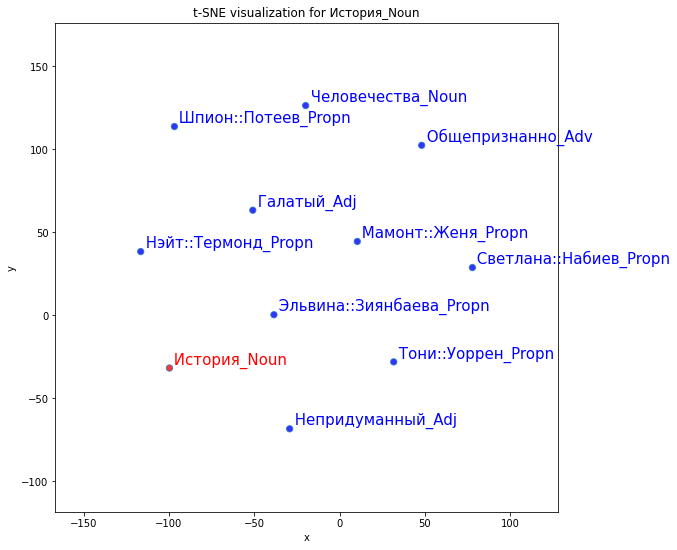

In [93]:
tsne_scatterplot(embeddings, "история", top_words1)

# FastText

https://www.kaggle.com/code/hongpeiyi/text-classification-with-fasttext
https://colab.research.google.com/github/PragmaticsLab/NLP-course-FinTech/blob/master/seminars/2/2_embeddings.ipynb#scrollTo=s-IW_cBDX-sp

https://rukshanjayasekara.wordpress.com/2022/05/13/text-classification-with-fasttext/
https://colab.research.google.com/github/NaiveNeuron/nlp-excercises/blob/master/tutorial2-fasttext/Text_Classification_fastText.ipynb
https://rukshanjayasekara.wordpress.com/2022/05/13/text-classification-with-fasttext/

In [19]:
df

,text,TargetClass
0,Сегодня у нас проходит т.н. гайдаровский форум...,1
1,Сбер представил отчет по РСБУ. Вклады населени...,0
2,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0
3,"Здравствуйте, сегодня наткнулся на ткую новост...",0
4,"Коммерсант сегодня написал, что Керимов хочет ...",1
...,...,...
1460,Сбербанк отмечает улучшение ситуации с реструк...,0
1461,Правительство России распространило действие п...,1
1462,Совкомбанк занимает 8 место по активам среди р...,0
1463,Правительство принимает «некоторые меры» для п...,0


In [20]:
df['TargetClass'].value_counts()

1    743
0    722
Name: TargetClass, dtype: int64

In [21]:
# Lets do some cleaning of this text
def clean_it(text,normalize=True):
    # Replacing possible issues with data. We can add or reduce the replacemtent in this chain
    s = str(text).replace(',',' ').replace('"','').replace('\'',' \' ').replace('.',' . ').replace('(',' ( ').\
            replace(')',' ) ').replace('!',' ! ').replace('?',' ? ').replace(':',' ').replace(';',' ').lower()
    
    s = re.sub(r'http\S+', '', s)
    s = s.replace(u'\xa0', u' ')
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    s = regex.sub(' ', s)
    s = re.sub(r'\s+', ' ', s)

    # normalizing / encoding the text
    if normalize:
        s = s.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')

    return s

# Now lets define a small function where we can use above cleaning on datasets
def clean_df(data, cleanit= False, shuffleit=False, encodeit=False, label_prefix='__class__'):
    # Defining the new data
    df = data.copy(deep=True)
    df['class'] = label_prefix + df['TargetClass'].astype(str) + ' '

    # cleaning it
    if cleanit:
        df['text'] = df['text'].apply(lambda x: clean_it(x,encodeit))
#         df['id'] = df['id'].apply(lambda x: clean_it(x,encodeit))

    # shuffling it
    if shuffleit:
        df.sample(frac=1).reset_index(drop=True)

    return df

In [22]:
%%time
# Transform the datasets using the above clean functions
data_train_cleaned = clean_df(df, True, True)

CPU times: total: 297 ms
Wall time: 297 ms


In [23]:
data_train_cleaned

,text,TargetClass,class
0,сегодня у нас проходит т н гайдаровский форум ...,1,__class__1
1,сбер представил отчет по рсбу вклады населения...,0,__class__0
2,мы будем предлагатьсказал улюкаев чтобы приват...,0,__class__0
3,здравствуйте сегодня наткнулся на ткую новость...,0,__class__0
4,коммерсант сегодня написал что керимов хочет о...,1,__class__1
...,...,...,...
1460,сбербанк отмечает улучшение ситуации с реструк...,0,__class__0
1461,правительство россии распространило действие п...,1,__class__1
1462,совкомбанк занимает 8 место по активам среди р...,0,__class__0
1463,правительство принимает «некоторые меры» для п...,0,__class__0


In [24]:
data_train_cleaned = data_train_cleaned[['class', 'text']]
data_train_cleaned

,class,text
0,__class__1,сегодня у нас проходит т н гайдаровский форум ...
1,__class__0,сбер представил отчет по рсбу вклады населения...
2,__class__0,мы будем предлагатьсказал улюкаев чтобы приват...
3,__class__0,здравствуйте сегодня наткнулся на ткую новость...
4,__class__1,коммерсант сегодня написал что керимов хочет о...
...,...,...
1460,__class__0,сбербанк отмечает улучшение ситуации с реструк...
1461,__class__1,правительство россии распространило действие п...
1462,__class__0,совкомбанк занимает 8 место по активам среди р...
1463,__class__0,правительство принимает «некоторые меры» для п...


In [25]:
X_train, X_test, y_train, y_test= train_test_split(data_train_cleaned.drop(['class'], axis=1), data_train_cleaned['class'], test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1172, 1), (293, 1), (1172,), (293,))

In [26]:
train = pd.concat([y_train, X_train], axis = 1).reset_index(drop=True)
train

,class,text
0,__class__0,сбербанк не поддержал введение института небан...
1,__class__0,цб рф не исключает повышения прогноза по прибы...
2,__class__1,к середине дня индекс мосбиржи торговался вбли...
3,__class__0,сбер вывел на рынок собственную платформу по в...
4,__class__0,автокредиты в октябре оказались самым депресси...
...,...,...
1167,__class__0,контракт «газпрома» с украиной может развалить...
1168,__class__1,сервис доставки продуктов «сбермаркет» перерег...
1169,__class__0,банк втб отчитался близко к прогнозу прибыль с...
1170,__class__0,«банки вернулись в хорошую форму пора думать о...


In [27]:
test = pd.concat([y_test, X_test], axis = 1).reset_index(drop=True)
test

,class,text
0,__class__1,втб управление инвестициями провела стратегиче...
1,__class__0,слабый рост чистых комиссий может быть компенс...
2,__class__0,«газпром» готов договариваться с «нафтогазом» ...
3,__class__1,в среду 31 июля сбербанк опубликует финансовые...
4,__class__1,выход глобальной экономики из «режима пандемии...
...,...,...
288,__class__0,прирост ипотечного портфеля в 2023г превысил 3...
289,__class__1,газообразные обещания почему новые предложения...
290,__class__0,мордашов заинтересовался покупкой доли в сети ...
291,__class__0,сбербанк планирует выкупить акции на сумму до ...


In [28]:
# Write files to disk as fastText classifier API reads files from disk.
train_file =  'train.csv'
train.to_csv(train_file, header=None, index=False, columns=['class','text'] )
test_file =  'test.csv'
test.to_csv(test_file, header=None, index=False, columns=['class','text'] )

In [29]:
"""fastText expects and training file (csv), a model name as input arguments.
label_prefix refers to the prefix before label string in the dataset.
default is __label__. In our dataset, it is __class__.
There are several other parameters which can be seen in:
https://pypi.org/project/fasttext/
"""
model7 = train_supervised(input=train_file, label="__class__", lr=1.0, epoch=100, loss='ova', wordNgrams=2, dim=200, thread=2, verbose=100)

In [30]:
model7.get_word_vector("хорошо")

array([ 4.70277388e-03,  3.27658211e-03,  1.17006823e-02, -2.27539744e-02,
        1.12598483e-02,  4.20230860e-03, -5.16136969e-03, -2.78879814e-02,
       -1.00221112e-02, -1.08292338e-03, -2.40237340e-02, -1.25146555e-02,
        1.21126901e-02, -1.72178075e-03,  3.64310201e-03,  2.14757286e-02,
        8.23559985e-03,  1.31368851e-02,  3.49544175e-03, -3.95038724e-03,
        7.02214567e-03,  1.45433284e-02,  1.15804654e-03,  4.09877719e-03,
        1.24823889e-02, -5.03262272e-03, -1.48990517e-03,  2.06843503e-02,
        1.96168991e-03,  2.36591659e-02,  1.34989619e-02,  7.10282568e-03,
        2.11357642e-02,  3.23739164e-02,  2.06180867e-02,  2.83607375e-02,
       -1.24558702e-03,  1.17399124e-03,  7.74009712e-03, -8.87977052e-03,
       -5.15351351e-03, -2.37789974e-02,  1.88095524e-04, -9.80076657e-05,
        4.23183152e-03, -1.16634304e-02,  3.17366095e-04, -8.76651891e-03,
       -1.77645627e-02, -2.44533774e-02,  3.33432741e-02,  7.74826296e-03,
       -2.74966680e-03, -

In [31]:
model7.get_nearest_neighbors('хорошо')

[(0.9767996072769165, 'обязательствам'),
 (0.9765377044677734, 'начинает'),
 (0.9764205813407898, 'компаниями'),
 (0.9763075113296509, 'сохраняет'),
 (0.9762691855430603, 'видит'),
 (0.9762370586395264, 'благодаря'),
 (0.9761258363723755, 'производству'),
 (0.9761194586753845, 'занять'),
 (0.9761006832122803, 'куда'),
 (0.9760592579841614, 'способны')]

In [32]:
# проблема с опечатками решена
model7.get_nearest_neighbors('хоршо')

[(0.0, 'по'),
 (0.0, 'на'),
 (0.0, 'с'),
 (0.0, 'руб'),
 (0.0, 'за'),
 (0.0, 'млрд'),
 (0.0, 'не'),
 (0.0, 'амстердамский'),
 (0.0, 'зарегистрирован'),
 (0.0, 'амстердамским')]

In [33]:
# проблема с out of vocabulary словами - тоже
model7.get_nearest_neighbors('moviegeek')

[(0.0, 'по'),
 (0.0, 'на'),
 (0.0, 'с'),
 (0.0, 'руб'),
 (0.0, 'за'),
 (0.0, 'млрд'),
 (0.0, 'не'),
 (0.0, 'амстердамский'),
 (0.0, 'зарегистрирован'),
 (0.0, 'амстердамским')]

In [34]:
model7.get_analogies("женщина", "мужчина", "актер")

[(0.0, 'по'),
 (0.0, 'на'),
 (0.0, 'с'),
 (0.0, 'руб'),
 (0.0, 'за'),
 (0.0, 'млрд'),
 (0.0, 'не'),
 (0.0, 'амстердамский'),
 (0.0, 'зарегистрирован'),
 (0.0, 'амстердамским')]

In [35]:
for k in range(1,6):
    results = model7.test(test_file,k=k)
    print(f"Test Samples: {results[0]} Precision@{k} : {results[1]*100:2.4f} Recall@{k} : {results[2]*100:2.4f}")

Test Samples: 293 Precision@1 : 54.9488 Recall@1 : 54.9488
Test Samples: 293 Precision@2 : 50.0000 Recall@2 : 100.0000
Test Samples: 293 Precision@3 : 50.0000 Recall@3 : 100.0000
Test Samples: 293 Precision@4 : 50.0000 Recall@4 : 100.0000
Test Samples: 293 Precision@5 : 50.0000 Recall@5 : 100.0000


In [36]:
ress1 = []
for sentence in tqdm(df['text']):
    # print(sentence)
    res = {}
#     sentence = sentence.replace("\n"," ")
    res['text'] = sentence
    # print(res['text'])
    preds = model7.predict(sentence)[0]
    # print(preds)
    if preds[0] == '__class__1':
                  label = 1
    else:
                  label = 0
    res['pred_class'] = label
    ress1.append(res)

  0%|          | 0/1465 [00:00<?, ?it/s]

In [37]:
itog1 = pd.DataFrame.from_dict(ress1)
itog1['class'] = df['TargetClass'].reset_index(drop=True)
itog1

,text,pred_class,class
0,Сегодня у нас проходит т.н. гайдаровский форум...,1,1
1,Сбер представил отчет по РСБУ. Вклады населени...,0,0
2,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0,0
3,"Здравствуйте, сегодня наткнулся на ткую новост...",0,0
4,"Коммерсант сегодня написал, что Керимов хочет ...",1,1
...,...,...,...
1460,Сбербанк отмечает улучшение ситуации с реструк...,0,0
1461,Правительство России распространило действие п...,1,1
1462,Совкомбанк занимает 8 место по активам среди р...,0,0
1463,Правительство принимает «некоторые меры» для п...,0,0


In [38]:
itog1.value_counts("pred_class")

pred_class
1    757
0    708
dtype: int64

In [39]:
f1 = metrics.f1_score(itog1['class'], itog1['pred_class'])
acc = metrics.accuracy_score(itog1['class'], itog1['pred_class'])
recall = metrics.precision_score(itog1['class'], itog1['pred_class'])
print('f1: {:.4f}, acc: {:.4f}, recall: {:.4f}'.format(f1, acc, recall))

f1: 0.8893, acc: 0.8867, recall: 0.8811


# Clove

https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html
    
https://debuggercafe.com/pretrained-glove-embeddings/

# RNN

In [ ]:
https://debuggercafe.com/text-classification-using-pytorch/
    
https://debuggercafe.com/disaster-tweet-classification-using-pytorch/
    
https://github.com/prakashpandey9/Text-Classification-Pytorch/tree/master
    
https://saturncloud.io/blog/pytorch-for-natural-language-processing-building-a-fake-news-classification-model/

In [40]:
# Set seed.
# seed = 42
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = True

In [19]:
df_rnn = pd.read_csv(f'{sym1}_dataset_news.csv')
df_rnn

,text,TargetClass
0,Сегодня у нас проходит т.н. гайдаровский форум...,1
1,Сбер представил отчет по РСБУ. Вклады населени...,0
2,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0
3,"Здравствуйте, сегодня наткнулся на ткую новост...",0
4,"Коммерсант сегодня написал, что Керимов хочет ...",1
...,...,...
1461,Правительство России распространило действие п...,1
1462,Совкомбанк занимает 8 место по активам среди р...,0
1463,Правительство принимает «некоторые меры» для п...,0
1464,Российские банки выдадут ипотечных кредитов по...,0


In [20]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = text.replace(u'\xa0', u' ')
    text = text.lower()
#     text = re.sub(r'[^\w\s]+|[\d]+', r'',text).strip()
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub(' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = " ".join(word for word in text.split() if word not in STOPWORDS)
#     text = " ".join(lemmatizer.normal_forms(word)[0] for word in text.split())
    return text
  
df_rnn['clean_text'] = df_rnn['text'].apply(clean_text)
df_rnn.head()

,text,TargetClass,clean_text
0,Сегодня у нас проходит т.н. гайдаровский форум...,1,сегодня проходит т н гайдаровский форум делают...
1,Сбер представил отчет по РСБУ. Вклады населени...,0,сбер представил отчет рсбу вклады населения 27...
2,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0,будем предлагатьсказал улюкаев приватизировать...
3,"Здравствуйте, сегодня наткнулся на ткую новост...",0,здравствуйте сегодня наткнулся ткую новость бу...
4,"Коммерсант сегодня написал, что Керимов хочет ...",1,коммерсант сегодня написал керимов хочет обкеш...


In [21]:
df_rnn['text'].loc[100]

'ВИРТУАЛЬНЫЙ ОПЕРАТОР СВЯЗИ СБЕРБАНКА НАЧНЕТ РАБОТУ ДО КОНЦА ЭТОГО ГОДАСбербанк планирует развивать услуги виртуального оператора связи (MNVO), используя инфраструктуру Tele2. Партнеры рассчитывают запустить пилотный проект в одном из регионов в ближайшем будущем, а затем развивать его в 65 регионах присутствия Tele2.Сбербанк еще официально не представил оператора MVNO. Проект позволит банку снизить операционные затраты, связанные с услугами связи, и более активно продвигать мобильные финансовые технологии. В настоящий момент нам сложно оценить, как проект повлияет на финансовые показатели Сбербанка, однако ранее банк заявлял, что только на рассылку СМС клиентам банк тратит $100 млн в год. \xa0\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 АТОН'

In [22]:
df_rnn['clean_text'].loc[100]

'виртуальный оператор связи сбербанка начнет работу конца годасбербанк планирует развивать услуги виртуального оператора связи mnvo используя инфраструктуру tele2 партнеры рассчитывают запустить пилотный проект одном регионов ближайшем будущем затем развивать 65 регионах присутствия tele2 сбербанк официально представил оператора mvno проект позволит банку снизить операционные затраты связанные услугами связи активно продвигать мобильные финансовые технологии настоящий момент нам сложно оценить проект повлияет финансовые показатели сбербанка однако ранее банк заявлял рассылку смс клиентам банк тратит 100 млн год атон'

In [23]:
def find_longest_length(data):
    """
    Find the longest review length in the entire training set.

    :param data.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for text in data['clean_text']:
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
            if len(corpus) > max_length:
                max_length = len(corpus)
    return max_length

longest = find_longest_length(df_rnn)
print(f"Longest review length: {longest} words")

Longest review length: 1159 words


In [24]:
def find_longest_length(data):
    """
    Find the longest review length in the entire training set.

    :param data.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for text in data['text']:
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
            if len(corpus) > max_length:
                max_length = len(corpus)
    return max_length

longest = find_longest_length(df_rnn)
print(f"Longest review length: {longest} words")

Longest review length: 1435 words


In [25]:
def find_avg_sentence_length(data):
    """
    Find the average sentence in the entire training set.

    :param data['text'].

    Returns:
        avg_len: Average length.
    """
    sentence_lengths = []
    for text in data['clean_text']:
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
            sentence_lengths.append(len(corpus))
    return sum(sentence_lengths)/len(sentence_lengths)

average_length = find_avg_sentence_length(df_rnn)
print(f"Average review length train: {average_length} words")

Average review length train: 217.72987721691678 words


In [26]:
def find_avg_sentence_length(data):
    """
    Find the average sentence in the entire training set.

    :param data['text'].

    Returns:
        avg_len: Average length.
    """
    sentence_lengths = []
    for text in data['text']:
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
            sentence_lengths.append(len(corpus))
    return sum(sentence_lengths)/len(sentence_lengths)

average_length = find_avg_sentence_length(df_rnn)
print(f"Average review length train: {average_length} words")

Average review length train: 269.7660300136426 words


In [27]:
class DatasetSeq(Dataset):
    def __init__(self, df):
        #open file
        self.train = df
#         self.train = pd.read_csv('SBERP_dataset_news.csv')
        # delete extra tag markup
        train1 = [x for x in self.train['clean_text']]
        
        #init vocabs of tokens for encoding { token:  id}
        self.word_vocab = {} # {cat: 1, sat: 2, on: 3, mat: 4, '.': 5}
        self.char_vocab = {} # {c: 1, a: 2, t: 3, ' ': 4, s: 5}

        # Cat sat on mat. -> [1, 2, 3, 4, 5]
        # p    a  r  p pu -> [1, 2, 3, 1, 4]
        # chars  -> [1, 2, 3, 4, 5, 2, 3, 4]

        #init encoded sequences lists (processed data)
        self.encoded_sequences = []
        self.encoded_char_sequences = []
        
        # n=1 because first (n=0) value is padding
        n_word = 1
        n_char = 1
        
        for line in train1:
            sequence = []
            chars = []
            
            for word in line.split(' '):
                if word != '':
                        
                        if self.word_vocab.get(word) is None:
                                    self.word_vocab[word] = n_word
                                    n_word += 1
                    
                        for char in word:
                                    if self.char_vocab.get(char) is None:
                                                self.char_vocab[char] = n_char
                                                n_char += 1
                    
                        sequence.append(self.word_vocab[word])
                        chars.append([self.char_vocab[char] for char in word])
            
            self.encoded_sequences.append(sequence)
            self.encoded_char_sequences.append(chars)

    def __len__(self):
        return len(self.encoded_sequences)

    def __getitem__(self, index):
        return {
            'data': self.encoded_sequences[index], # [1, 2, 3, 4, 6] len=5
            'char': self.encoded_char_sequences[index],# [[1,2,3], [4,5], [1,2], [2,6,5,4], []] len=5
            'target': self.train['TargetClass'].loc[index], #  (1)
        }

In [28]:
dataset = DatasetSeq(df_rnn)

In [29]:
dataset.__len__()

1466

In [249]:
# dataset.__getitem__(1)

In [31]:
def collate_fn(input_data):
    
    data = []
    chars = []
    targets = []
    max_len = 0
    
    for item in input_data:
        if len(item['data']) > max_len:
            max_len = len(item['data'])
        data.append(torch.as_tensor(item['data']))
        chars.append(item['char'])
        targets.append(torch.as_tensor(item['target']))
    
    chars_seq = [[torch.as_tensor([0]) for _ in range(len(input_data))] for _ in range(max_len)]
    
    for j in range(len(input_data)):
        for i in range(max_len):
            if len(chars[j]) > i:
                chars_seq[i][j] = torch.as_tensor(chars[j][i])
    
    for j in range(max_len):
        chars_seq[j] = pad_sequence(chars_seq[j], batch_first=True, padding_value=0)
    
    data = pad_sequence(data, batch_first=True, padding_value=0)
    targets = torch.tensor(targets, dtype=torch.float32)
    
    return {'data': data, 'chars': chars_seq, 'target': targets}

In [42]:
#hyper params
vocab_size = len(dataset.word_vocab) + 1
n_classes = 1
n_chars = len(dataset.char_vocab) + 1
#TODO try to use other model parameters
emb_dim = 256 # поменял с 256 на 128
hidden = 256
char_hid = 64
char_emb = 32
n_epochs = 10
batch_size = 16
cuda_device = -1
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'
print(device)

cpu


In [43]:
train_size = int(0.9 * len(dataset))
size = len(dataset) - train_size
val_size = int(0.5 * size)
test_size = size - val_size
# train_size, val_size, test_size, len(dataset), train_size + val_size + test_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [44]:
len(train_dataset), len(val_dataset), len(test_dataset)

(1319, 73, 74)

In [45]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, collate_fn=collate_fn, drop_last = True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, collate_fn=collate_fn, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, collate_fn=collate_fn, drop_last = True)

In [46]:
len(train_dataloader.dataset)

1319

In [47]:
class CharRNN_GRU(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        super().__init__()
        self.char_emb = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        emb = self.char_emb(x) # B x T x Emb_dim
        _, out = self.rnn(emb)
        # _: B x T x Hidden
        # out: 1 x B x Hidden

        return out.transpose(0, 1) # B x 1 x Hidden

In [48]:
class RNN_GRU_CH(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, hidden_dim, n_classes,
                 char_vocab, char_emb, char_hidden):
        super().__init__()
        #TODO try to use other RNN archicetures, f.e. RNN and LSTM
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        # batch_first = False: T x B x Vec
        # batch_first = True: B x T x Vec
        self.rnn = nn.GRU(emb_dim + char_hidden, hidden_dim, num_layers=1, batch_first=True, bidirectional=False)
        self.clf = nn.Linear(hidden_dim, n_classes)
        self.do = nn.Dropout(0.2)
        self.hidden_dim = hidden_dim
        self.char_rnn = CharRNN_GRU(char_vocab, char_emb, char_hidden)

    def forward(self, x, chars):
        emb = self.word_emb(x)
        char_features = [self.char_rnn(c.to(x.device)) for c in chars]
        char_features = torch.cat(char_features, dim=1) # конкатенация по времени B x T x Char_hid
        emb = torch.cat((emb, char_features), dim=-1) # конкатенация векторов
        output, context = self.rnn(emb)
        
#         print(output.shape, context.shape)

        out = self.clf(self.do(context))
    
        return out.view(-1)

In [49]:
model = RNN_GRU_CH(vocab_size, emb_dim, hidden, n_classes, n_chars, char_emb, char_hid).to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

RNN_GRU_CH(
  (word_emb): Embedding(44013, 256)
  (rnn): GRU(320, 256, batch_first=True)
  (clf): Linear(in_features=256, out_features=1, bias=True)
  (do): Dropout(p=0.2, inplace=False)
  (char_rnn): CharRNN_GRU(
    (char_emb): Embedding(105, 32)
    (rnn): GRU(32, 64, batch_first=True)
  )
)
11,733,665 total parameters.
11,733,665 training parameters.



In [50]:
batch = next(iter(train_dataloader))
# batch['data'].shape, len(batch['chars']), batch['target'].shape
predict = model(batch['data'].to(device), batch['chars'])
predict.shape, batch['target'].shape

torch.Size([16, 657, 256]) torch.Size([1, 16, 256])


(torch.Size([16]), torch.Size([16]))

In [239]:
def binary_accuracy(labels, outputs, train_running_correct):
    # As the outputs are currently logits.
    outputs = torch.sigmoid(outputs)
    running_correct = 0
    for i, label in enumerate(labels):
        if label < 0.5 and outputs[i] < 0.5:
            running_correct += 1
        elif label >= 0.5 and outputs[i] >= 0.5:
            running_correct += 1
    return running_correct

In [240]:
# Training function.
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        inputs, chars, labels = data['data'], data['chars'], data['target']
        inputs = inputs.to(device)
#         labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(inputs, chars)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        running_correct = binary_accuracy(
            labels, outputs, train_running_correct
        )
        train_running_correct += running_correct
        # Backpropagation.
        loss.backward()
        # Update the optimizer parameters.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# Validation function.
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            inputs, chars, labels = data['data'], data['chars'], data['target']
            inputs = inputs.to(device)
#             labels = labels.to(device)
            # Forward pass.
            outputs = model(inputs, chars)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            running_correct = binary_accuracy(
                labels, outputs, valid_running_correct
            )
            valid_running_correct += running_correct
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
epochs = n_epochs
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, 
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_dataloader,  
                                                criterion, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}")
    # Save model.
    torch.save(model, 'model.pth')
    
    print('-'*50)

In [ ]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='red', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
#     plt.savefig('accuracy.png')
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig('loss.png')
    plt.show()
save_plots(train_acc, valid_acc, train_loss, valid_loss)

In [ ]:
test_model = torch.load('model.pth')

In [ ]:
test_running_correct = 0
with torch.no_grad():
    model.eval()
    for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
            counter += 1
            inputs, chars, labels = data['data'], data['chars'], data['target']
            inputs = inputs.to(device)
            outputs = test_model(inputs, chars)
            running_correct = binary_accuracy(
                labels, outputs, test_running_correct
            )
            test_running_correct += running_correct
test_acc = 100. * (test_running_correct / len(test_dataloader.dataset))

# Attention

In [243]:
class Attention_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v):

        attn = torch.bmm(q, # B x T1 x V
                         k.transpose(1, 2), # B x T2 x V -> B x V x T2
                         ) # B x T1 x T2

        attn = self.softmax(attn)
        
        attn = self.dropout(attn)
       
        output = torch.bmm(attn, v) # B x T1 x T2 @ B x T1 x V

        return output

In [281]:
class RNN_GRU_CH_Attention(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, n_classes,
                 char_vocab, char_emb, char_hidden):
        super().__init__()
        #TODO try to use other RNN archicetures, f.e. RNN and LSTM
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        # batch_first = False: T x B x Vec
        # batch_first = True: B x T x Vec
        self.rnn = nn.GRU(emb_dim + char_hidden, hidden_dim, num_layers=1, batch_first=True, bidirectional=False)
        self.clf = nn.Linear(hidden_dim*2, n_classes)
        self.do = nn.Dropout(0.2)
        self.hidden_dim = hidden_dim
        self.char_rnn = CharRNN_GRU(char_vocab, char_emb, char_hidden)
        self.attn = Attention_net()


    def forward(self, x, chars):
       
        emb = self.word_emb(x)
        char_features = [self.char_rnn(c.to(x.device)) for c in chars]
        char_features = torch.cat(char_features, dim=1) # конкатенация по времени B x T x Char_hid
        emb = torch.cat((emb, char_features), dim=-1) # конкатенация векторов
        
        output, context = self.rnn(emb)   
#         print(context.shape)
        context = context.permute(1, 0, 2)
        attn_output = self.attn(context, output, output)
        out = self.do(torch.cat((context, attn_output), dim=-1))
        out = self.clf(out)
        
        return  out.view(-1)

In [282]:
model_a = RNN_GRU_CH_Attention(vocab_size, emb_dim, hidden, n_classes, n_chars, char_emb, char_hid).to(device)
print(model_a)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_a.parameters(), lr=0.001,)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_a.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model_a.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

RNN_GRU_CH_Attention(
  (word_emb): Embedding(44013, 256)
  (rnn): GRU(320, 256, batch_first=True)
  (clf): Linear(in_features=512, out_features=1, bias=True)
  (do): Dropout(p=0.2, inplace=False)
  (char_rnn): CharRNN_GRU(
    (char_emb): Embedding(105, 32)
    (rnn): GRU(32, 64, batch_first=True)
  )
  (attn): Attention_net(
    (dropout): Dropout(p=0.1, inplace=False)
    (softmax): Softmax(dim=2)
  )
)
11,733,921 total parameters.
11,733,921 training parameters.



In [283]:
batch = next(iter(train_dataloader))
# batch['data'].shape, len(batch['chars']), batch['target'].shape
predict = model_a(batch['data'].to(device), batch['chars'])
# loss = criterion(predict, batch['target'].to(device))
predict.shape, batch['target'].shape
# loss

(torch.Size([16]), torch.Size([16]))

In [ ]:
epochs = n_epochs
# Lists to keep track of losses and accuracies.
train_loss2, valid_loss2 = [], []
train_acc2, valid_acc2 = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model_a, train_dataloader, 
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(model_a, val_dataloader,  
                                                criterion, device)
    train_loss2.append(train_epoch_loss)
    valid_loss2.append(valid_epoch_loss)
    train_acc2.append(train_epoch_acc)
    valid_acc2.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}")
    # Save model.
    torch.save(model_a, 'model_a.pth')
    
    print('-'*50)

In [ ]:
save_plots(train_acc2, valid_acc2, train_loss2, valid_loss2)

In [ ]:
test_model_a = torch.load('model_a.pth')

In [ ]:
test_running_correct = 0
model_a.eval()
for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
            counter += 1
            inputs, chars, labels = data['data'], data['chars'], data['target']
            inputs = inputs.to(device)
            outputs = test_model_a(inputs, chars)
            running_correct = binary_accuracy(
                labels, outputs, test_running_correct
            )
            test_running_correct += running_correct
test_acc2 = 100. * (test_running_correct / len(test_dataloader.dataset))
print(test_acc2)

# Bert

https://saturncloud.io/blog/pytorch-for-natural-language-processing-building-a-fake-news-classification-model/

# Transformer 

https://debuggercafe.com/text-classification-using-transformer-encoder-in-pytorch/
    
https://debuggercafe.com/language-translation-using-pytorch-transformer/
    
https://debuggercafe.com/transformer-neural-network/